In [136]:
import pyvo
from astropy.io.votable import from_table
from astropy.coordinates import SkyCoord
from astropy.io.votable import parse
import astropy.units as units
from astropy.units import Quantity


# ipywidets gives us control over java script from the jupyter notebook. We use this for the buttons. 
import ipywidgets as widgets
from IPython.display import clear_output
from IPython.display import display

# cds tools
import ipyaladin.aladin_widget as ipyal
from astroquery.cds import cds

"""Get information of stars in the Orion Cluster from SIMBAD"""
simbad=pyvo.registry.search(servicetype="tap",keywords="simbad")
print(simbad)
# Make the TAP service object
service = pyvo.dal.TAPService ("https://simbad.cds.unistra.fr/simbad/sim-tap")

# Query the TAP service with a simple ADQL query.
stars = service.search ("""
SELECT
   distinct main_id,ra, dec, cats.id
    FROM ident AS orion,basic 
    JOIN ident AS cats 
    ON basic.oid=cats.oidref 
    JOIN h_link ON (oid=child 
    AND parent=orion.oidref)
    WHERE orion.id = 'Orion Cluster' 
    AND membership >=90
    AND cats.id LIKE 'Gaia DR3 %' 
    AND basic.otype = 'V*..' 

  """)
stars.broadcast_samp('Aladin')

<Table length=1>
       ivoid              res_type     short_name        res_title        ...      standard_ids       intf_types  intf_roles
                                                                          ...                                               
       object              object        object            object         ...         object            object      object  
-------------------- ----------------- ---------- ----------------------- ... ---------------------- ------------ ----------
ivo://cds.simbad/tap vs:catalogservice SIMBAD TAP SIMBAD TAP query engine ... ivo://ivoa.net/std/tap vs:paramhttp        std


In [16]:
"""X-match with the ESA gaia DR3 catalog"""

esa_service = pyvo.dal.TAPService ("https://gea.esac.esa.int/tap-server/tap")

orion = esa_service.search ("""
    SELECT
    
    simbad.main_id, source_id, designation, 
    phot_variable_flag,phot_g_mean_mag, 
    phot_bp_mean_mag, phot_rp_mean_mag, 
    gaia.ra, gaia.dec,parallax, pm, 
    pmra, pmdec, radial_velocity 
    
    FROM gaiadr3.gaia_source AS gaia
    
    JOIN TAP_UPLOAD.simbad AS simbad
    ON simbad.id=designation
    
    WHERE has_epoch_photometry ='t'
    """, uploads={'simbad':stars})
orion.broadcast_samp('Aladin')

In [44]:
"""Let's try to find SAMP clients listening on our machine"""

from astropy.samp import SAMPIntegratedClient

def find_samp_clients(mtype):
    # Make SAMP client object
    samp_cl = SAMPIntegratedClient()

    # Connect to SAMP hub
    samp_cl.connect()

    # Get list of SAMP Clients
    cls = samp_cl.get_subscribed_clients(mtype)
    
    clients={}

    for client in cls:
        if not client == 'hub':
            # Resolve client number to client Name 
            clients[samp_cl.get_metadata(client)['samp.name']]=client

    # Keep the SAMP hub sane
    samp_cl.disconnect()
    
    return clients

clients_votable = find_samp_clients('table.load.votable')
print(clients_votable)

{'Aladin': 'c1', 'Cassis': 'c2'}


In [45]:
import matplotlib.pyplot as plt

def draw_plot(to_plot, 
                colours  = ['green', 'red', 'blue'], 
                title = 'Epoch photometry', 
                fontsize = 12, 
                show_legend = True, 
                show_grid = True, 
                figsize = [15,5]):
    """
    Epoch photometry plotter. 'inp_table' MUST be an Astropy-table object.
    """
    (title,inp_table,cols) = to_plot
    xcol, ycol, col_p = cols
    fig  = plt.figure(figsize=figsize)
    xlabel   = f'JD date [{inp_table[xcol].unit}]'
    ylabel   = f'magnitude [{inp_table[ycol].unit}]'
    gbands   = ['G', 'RP', 'BP']
    colours  = iter(colours)

    plt.gca().invert_yaxis()
    for band in gbands:
        phot_set = inp_table[inp_table[col_p] == band]
        plt.plot(phot_set[xcol], 
                 phot_set[ycol], 
                 'o', 
                 label = band, 
                 color = next(colours))

    make_canvas(title = title, 
                xlabel = xlabel, 
                ylabel = ylabel, 
                fontsize= fontsize, 
                show_legend=show_legend, 
                show_grid = show_grid)
    return


def make_canvas(
                title ='',
                xlabel = '', 
                ylabel = '', 
                show_grid = False, 
                show_legend = False, 
                fontsize = 12):
    """
    Create generic canvas for plots
    """

    plt.title(title,
          fontsize = fontsize)
    plt.xlabel(xlabel, 
           fontsize = fontsize)
    plt.ylabel(ylabel, 
           fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)

    if show_grid:
        plt.grid()
    if show_legend:
        plt.legend(fontsize = fontsize*0.75)
    

In [106]:
# Useful things
class TableIndex():
    
    def forward (self):
        self.index+=1
    def rewind (self):
        self.index-=1    
    def __init__(self):
        self.index=0

class Spectrum():
    spec=None
    
def make_coord(row):
    coord=SkyCoord(row['ra']*units.deg, row['dec']*units.deg, frame='icrs')
    return coord

In [119]:
index=TableIndex()
spectrum=Spectrum()

def get_url_from_datalink(row):
    """From the datalink make the URL to the lightcurve"""
    
    dl=row.getdatalink()
 
    # There may be more than one datalink, so get the one with the lc of g band 
    for i in dl:
        if i['description'].find('Epoch photometry')!=-1:
            # Use the access_url attribut
            accurl=str(i['access_url'])           
    return accurl


def get_lctable(row):
    "Get the lightcurves through the datalink"
    
    # First make the url of the lightcurve
    url=get_url_from_datalink(row)
    
    # Then download the lightcurve table from the URL
    # Parse the VOTable from the link -- we have the lightcurve
    lctable=parse(url)
    
    return lctable

def get_colname_from_ucd(fields, ucdpattern):
    """
    Searches through the fields of an astropy votable object and returns
    the list of matches
    """

    matches=[]

    for field in fields:
        if field.ucd:
            ucd=field.ucd.lower()
            if ucd.find(ucdpattern.lower())!=-1:
                matches.append(field.name)
    return matches

def get_colnames(lc_vot):
    """
    Searches specific UCDs, and keep only these columns
    """
    ucds=['time.epoch','phot.mag;em.opt', 'instr.bandpass']
    cols=[]
    for ucd in ucds:
        cols.append(get_colname_from_ucd(lc_vot.fields,ucd)[0])
    return tuple(cols)


def search_spectrum(coord):
    
    # Gaia DR3 MC sampled XP spectra SSA from GAVO DC
    ssa_service = pyvo.dal.SSAService("http://dc.zah.uni-heidelberg.de/gaia/s3/ssa/ssap.xml?")
    ssa_results = ssa_service.search(pos = coord, diameter=Quantity(10, unit="arcsec"))
    return ssa_results


def make_buttons(spectrum):
    
    bns=[]

    bn=widgets.Button(description = 'Previous')
    bn.on_click(previous_row)        
    bns.append(bn)
    bn=widgets.Button(description = 'Next')
    bn.on_click(next_row) 
    bns.append(bn)
    
    if ('Cassis' in clients_votable and spectrum):
        bn=widgets.Button(description = 'SAMP: Cassis')
        bn.on_click(send_spect_to_cassis)
        bns.append(bn)
    
    return bns


def send_spect_to_cassis(btn, spectrum=spectrum):
    if spectrum.spec: spectrum.spec.broadcast_samp('Cassis')
        
def previous_row(btn, orion=orion, index=index):
    index.rewind()
    clear_output()
    btn_action(orion, index)

def next_row(btn, orion=orion, index=index):
    index.forward()
    clear_output()
    btn_action(orion, index)

    
def display_buttons(firstrow):
    hbfirst = widgets.HBox(firstrow)
    return hbfirst

    
def make_plot (title, lctable, colnames):
    to_plot=(title,lctable,colnames)
    return draw_plot(to_plot)

    
def btn_action (orion, index=index):
    
    ind=index.index
    row=orion[ind]
    lctable=get_lctable(row)
    name=row['main_id']

    # Search for Spectrum in the new position
    ssa_results=search_spectrum(make_coord(row))
    if len(ssa_results)>=1:
        spectrum.spec=ssa_results[0]
    else:
        spectrum.spec=None
        
    # create buttons previous/next
    bns=make_buttons(spectrum.spec)
    # Show the buttons
    hbox1 = widgets.HBox(bns)    
    display (hbox1)

    # Prepare the light curve plot
    # get colnames from ucds and table
    colnames=get_colnames(lctable.get_first_table())
    to_plot=(name, lctable.get_first_table().to_table(), colnames)
    # Show the plot
    draw_plot(to_plot) 
    
    # Move the AladinLite preview
    aladin.target=name
    aladin.fov=0.2
        


In [77]:
# create Aladin view
survey = cds.find_datasets(meta_data="ID=*P/XMM*")['hips_service_url_1'][0]
aladin = ipyal.Aladin(survey=survey,
                show_coo_grid=True,
                target='Orion Cluster',
                coo_frame="galactic",
                fov=2,
                )
aladin

Aladin(coo_frame='galactic', fov=2.0, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log',…

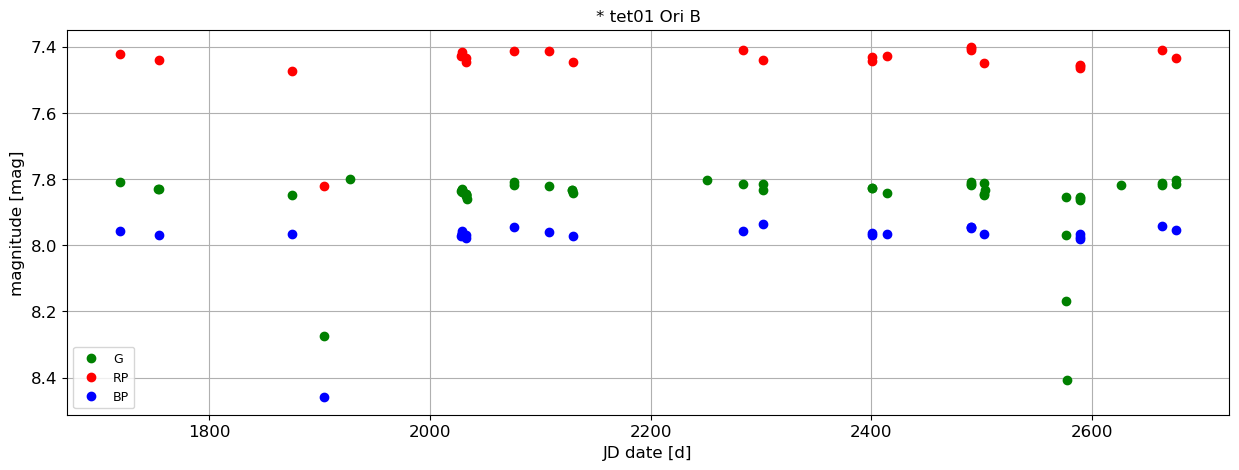

In [120]:
index=TableIndex()

btn_action (orion, index)